In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

sns.set(style='whitegrid')
print('✓ Libraries imported successfully!')

✓ Libraries imported successfully!


In [2]:
# Load merged dataset from Phase 2
df = pd.read_csv('../outputs/processed/space_weather_master.csv')
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'])

print(f'✓ Data loaded: {df.shape[0]} rows')
print(f'\nData Coverage:')
print(f'  Total rows: {len(df)}')
print(f'  Kp data rows: {(df["median"].notna()).sum()}')
print(f'  Solar wind data rows: {(df["Speed"].notna()).sum()}')

# Separate datasets
kp_data = df[df['median'].notna()].copy()
solar_data = df[df['Speed'].notna()].copy()

print(f'\nKp data time range: {kp_data["Time (UTC)"].min()} to {kp_data["Time (UTC)"].max()}')
print(f'Solar wind time range: {solar_data["Time (UTC)"].min()} to {solar_data["Time (UTC)"].max()}')

✓ Data loaded: 169 rows

Data Coverage:
  Total rows: 169
  Kp data rows: 25
  Solar wind data rows: 144

Kp data time range: 2025-11-12 18:00:00 to 2025-11-15 18:00:00
Solar wind time range: 2025-08-15 00:00:00 to 2025-08-20 23:00:00


In [3]:
# Analyze Kp Index
print('\n' + '='*70)
print('KP INDEX STATISTICS (Nov 12-15, 2025)')
print('='*70)

print(f'\nDescriptive Statistics:')
print(f'  Mean: {kp_data["median"].mean():.2f}')
print(f'  Median: {kp_data["median"].median():.2f}')
print(f'  Std Dev: {kp_data["median"].std():.2f}')
print(f'  Min: {kp_data["median"].min():.2f}')
print(f'  Max: {kp_data["median"].max():.2f}')

print(f'\nKp Range Distribution:')
for kp_level in [3, 4, 5, 6, 7, 8, 9]:
    count = (kp_data['median'] >= kp_level).sum()
    pct = (count / len(kp_data)) * 100
    print(f'  Kp >= {kp_level}: {count} records ({pct:.1f}%)')


KP INDEX STATISTICS (Nov 12-15, 2025)

Descriptive Statistics:
  Mean: 2.99
  Median: 2.33
  Std Dev: 1.54
  Min: 1.33
  Max: 7.00

Kp Range Distribution:
  Kp >= 3: 11 records (44.0%)
  Kp >= 4: 8 records (32.0%)
  Kp >= 5: 3 records (12.0%)
  Kp >= 6: 1 records (4.0%)
  Kp >= 7: 1 records (4.0%)
  Kp >= 8: 0 records (0.0%)
  Kp >= 9: 0 records (0.0%)


In [4]:
# Define event detection thresholds
EVENT_THRESHOLDS = {
    'quiet': 3.0,
    'unsettled': 4.0,
    'active': 5.0,
    'minor_storm': 6.0,
    'moderate_storm': 7.0,
    'strong_storm': 8.0,
    'severe_storm': 9.0
}

# Function to detect events
def detect_events(data, col='median', thresholds=None):
    """
    Classify geomagnetic activity based on Kp thresholds
    """
    if thresholds is None:
        thresholds = EVENT_THRESHOLDS
    
    events = []
    
    for idx, row in data.iterrows():
        kp_value = row[col]
        time = row['Time (UTC)']
        
        if kp_value >= thresholds['severe_storm']:
            severity = 'Severe Storm'
            level = 7
        elif kp_value >= thresholds['strong_storm']:
            severity = 'Strong Storm'
            level = 6
        elif kp_value >= thresholds['moderate_storm']:
            severity = 'Moderate Storm'
            level = 5
        elif kp_value >= thresholds['minor_storm']:
            severity = 'Minor Storm'
            level = 4
        elif kp_value >= thresholds['active']:
            severity = 'Active'
            level = 3
        elif kp_value >= thresholds['unsettled']:
            severity = 'Unsettled'
            level = 2
        else:
            severity = 'Quiet'
            level = 1
        
        events.append({
            'Time': time,
            'Kp': kp_value,
            'Severity': severity,
            'Level': level
        })
    
    return pd.DataFrame(events)

# Detect events
events_df = detect_events(kp_data)

print(f'\n✓ Geomagnetic Activity Classification:')
print(f'  Total observations: {len(events_df)}')
print(f'\n  Breakdown by category:')
severity_counts = events_df['Severity'].value_counts().sort_values(ascending=False)
for severity, count in severity_counts.items():
    pct = (count / len(events_df)) * 100
    print(f'    {severity}: {count} ({pct:.1f}%)')

print(f'\nDetailed Event List:')
print(events_df.to_string(index=False))


✓ Geomagnetic Activity Classification:
  Total observations: 25

  Breakdown by category:
    Quiet: 17 (68.0%)
    Unsettled: 5 (20.0%)
    Active: 2 (8.0%)
    Moderate Storm: 1 (4.0%)

Detailed Event List:
               Time       Kp       Severity  Level
2025-11-12 18:00:00 7.000000 Moderate Storm      5
2025-11-12 21:00:00 5.000000         Active      3
2025-11-13 00:00:00 4.333333      Unsettled      2
2025-11-13 03:00:00 4.333333      Unsettled      2
2025-11-13 06:00:00 4.333333      Unsettled      2
2025-11-13 09:00:00 5.000000         Active      3
2025-11-13 12:00:00 4.666666      Unsettled      2
2025-11-13 15:00:00 4.333333      Unsettled      2
2025-11-13 18:00:00 3.666666          Quiet      1
2025-11-13 21:00:00 3.666666          Quiet      1
2025-11-14 00:00:00 3.000000          Quiet      1
2025-11-14 03:00:00 2.666666          Quiet      1
2025-11-14 06:00:00 2.333333          Quiet      1
2025-11-14 09:00:00 2.000000          Quiet      1
2025-11-14 12:00:00 2.000

In [5]:
# Generate storm catalog by grouping consecutive events
def generate_storm_catalog(events_df):
    """
    Group consecutive high-activity events into storm episodes
    (storms are events with Kp >= 5, grouped within 6 hours)
    """
    if len(events_df) == 0:
        return pd.DataFrame()
    
    # Sort by time
    events_df = events_df.sort_values('Time').reset_index(drop=True)
    
    # Filter for storm-level events (Kp >= 5)
    storm_events = events_df[events_df['Level'] >= 4].copy()
    
    if len(storm_events) == 0:
        return pd.DataFrame()
    
    # Group consecutive events (within 6 hours = 1 storm)
    catalog = []
    current_storm = None
    
    for idx, event in storm_events.iterrows():
        if current_storm is None:
            # Start new storm
            current_storm = {
                'Storm_ID': len(catalog) + 1,
                'Start_Time': event['Time'],
                'End_Time': event['Time'],
                'Peak_Kp': event['Kp'],
                'Peak_Severity': event['Severity'],
                'Duration_Hours': 0,
                'Events_Count': 1,
                'Kp_Values': [event['Kp']]
            }
        else:
            # Check if within 6 hours of last event
            time_diff = (event['Time'] - current_storm['End_Time']).total_seconds() / 3600
            
            if time_diff <= 6:
                # Add to current storm
                current_storm['End_Time'] = event['Time']
                current_storm['Duration_Hours'] = (
                    (event['Time'] - current_storm['Start_Time']).total_seconds() / 3600
                )
                current_storm['Peak_Kp'] = max(current_storm['Peak_Kp'], event['Kp'])
                current_storm['Events_Count'] += 1
                current_storm['Kp_Values'].append(event['Kp'])
                
                # Update severity if higher
                severity_order = {
                    'Active': 3, 'Minor Storm': 4, 'Moderate Storm': 5,
                    'Strong Storm': 6, 'Severe Storm': 7
                }
                if severity_order.get(event['Severity'], 0) > severity_order.get(current_storm['Peak_Severity'], 0):
                    current_storm['Peak_Severity'] = event['Severity']
            else:
                # New storm
                current_storm['Avg_Kp'] = np.mean(current_storm['Kp_Values'])
                catalog.append(current_storm)
                
                current_storm = {
                    'Storm_ID': len(catalog) + 1,
                    'Start_Time': event['Time'],
                    'End_Time': event['Time'],
                    'Peak_Kp': event['Kp'],
                    'Peak_Severity': event['Severity'],
                    'Duration_Hours': 0,
                    'Events_Count': 1,
                    'Kp_Values': [event['Kp']]
                }
    
    if current_storm is not None:
        current_storm['Avg_Kp'] = np.mean(current_storm['Kp_Values'])
        catalog.append(current_storm)
    
    # Remove the Kp_Values list for final dataframe
    for storm in catalog:
        del storm['Kp_Values']
    
    return pd.DataFrame(catalog)

# Generate catalog
storm_catalog = generate_storm_catalog(events_df)

print(f'\n✓ Storm Catalog Generated:')
print(f'  Total distinct storms: {len(storm_catalog)}')
if len(storm_catalog) > 0:
    print(f'\n{storm_catalog.to_string(index=False)}')
else:
    print('  No storms detected (all events below Kp=5)')


✓ Storm Catalog Generated:
  Total distinct storms: 1

 Storm_ID          Start_Time            End_Time  Peak_Kp  Peak_Severity  Duration_Hours  Events_Count  Avg_Kp
        1 2025-11-12 18:00:00 2025-11-12 18:00:00      7.0 Moderate Storm               0             1     7.0


In [6]:
# Save results
os.makedirs('../outputs/processed', exist_ok=True)

if len(storm_catalog) > 0:
    storm_catalog.to_csv('../outputs/processed/storm_catalog.csv', index=False)
    print('✓ Storm catalog saved to: ../outputs/processed/storm_catalog.csv')

events_df.to_csv('../outputs/processed/geomagnetic_events.csv', index=False)
print('✓ Events file saved to: ../outputs/processed/geomagnetic_events.csv')

✓ Storm catalog saved to: ../outputs/processed/storm_catalog.csv
✓ Events file saved to: ../outputs/processed/geomagnetic_events.csv


✓ Figure saved: 06_kp_timeseries.png


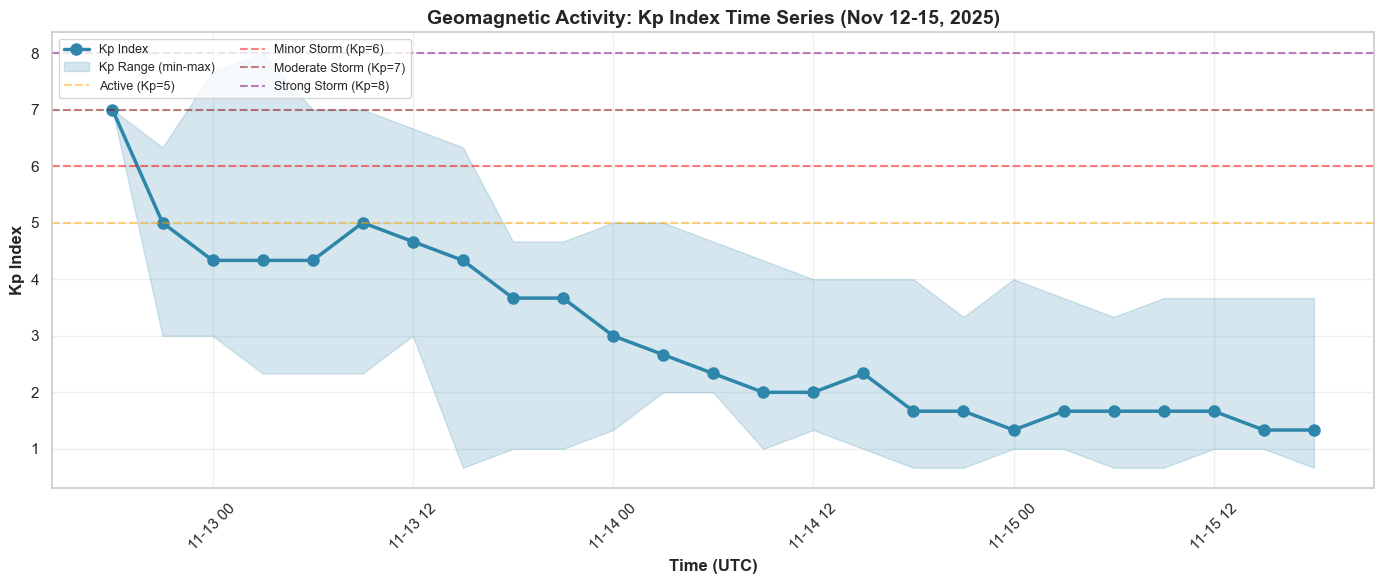

In [7]:
# Visualization 1: Kp Time Series with Events
fig, ax = plt.subplots(figsize=(14, 6))

# Plot Kp time series
ax.plot(kp_data['Time (UTC)'], kp_data['median'], 
        linewidth=2.5, color='#2E86AB', marker='o', markersize=8, label='Kp Index')
ax.fill_between(kp_data['Time (UTC)'], kp_data['minimum'], kp_data['maximum'], 
                alpha=0.2, color='#2E86AB', label='Kp Range (min-max)')

# Add activity level threshold lines
ax.axhline(y=5, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Active (Kp=5)')
ax.axhline(y=6, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Minor Storm (Kp=6)')
ax.axhline(y=7, color='darkred', linestyle='--', linewidth=1.5, alpha=0.5, label='Moderate Storm (Kp=7)')
ax.axhline(y=8, color='purple', linestyle='--', linewidth=1.5, alpha=0.5, label='Strong Storm (Kp=8)')

ax.set_xlabel('Time (UTC)', fontsize=12, fontweight='bold')
ax.set_ylabel('Kp Index', fontsize=12, fontweight='bold')
ax.set_title('Geomagnetic Activity: Kp Index Time Series (Nov 12-15, 2025)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
fig.savefig('../outputs/figures/06_kp_timeseries.png', dpi=300, bbox_inches='tight')
print('✓ Figure saved: 06_kp_timeseries.png')
plt.show()

✓ Figure saved: 07_activity_distribution.png


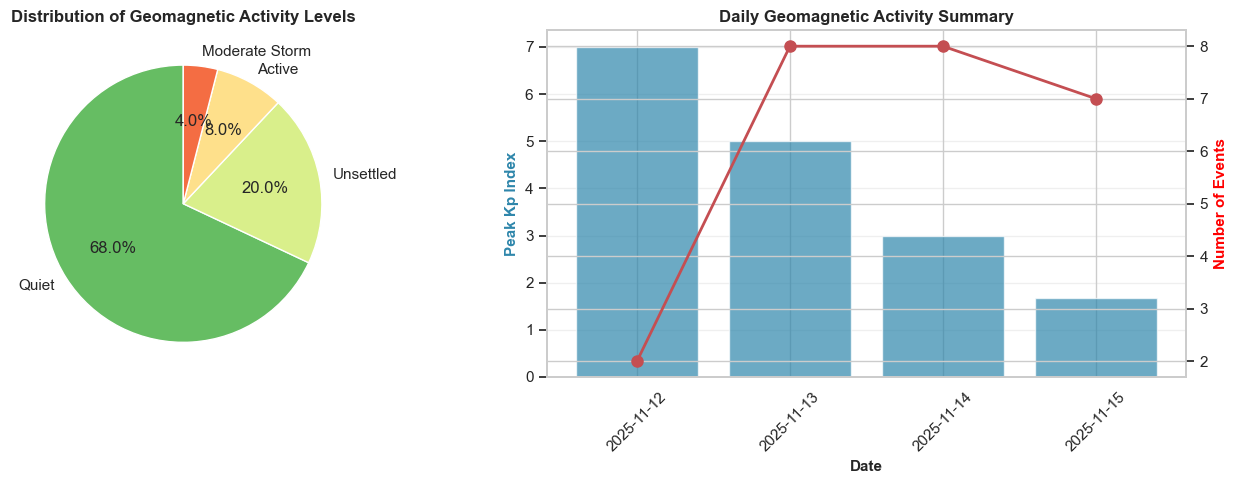

In [8]:
# Visualization 2: Geomagnetic Activity Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of activity levels
severity_counts = events_df['Severity'].value_counts()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(severity_counts)))
ax1.pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Distribution of Geomagnetic Activity Levels', fontsize=12, fontweight='bold')

# Bar chart of activity by day
kp_data['Date'] = kp_data['Time (UTC)'].dt.date
daily_max = kp_data.groupby('Date')['median'].max()
daily_count = kp_data.groupby('Date').size()

ax2_twin = ax2.twinx()
bars = ax2.bar(range(len(daily_max)), daily_max.values, color='#2E86AB', alpha=0.7, label='Peak Kp')
line = ax2_twin.plot(range(len(daily_count)), daily_count.values, 'ro-', linewidth=2, 
                     markersize=8, label='Event Count')

ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Peak Kp Index', fontsize=11, fontweight='bold', color='#2E86AB')
ax2_twin.set_ylabel('Number of Events', fontsize=11, fontweight='bold', color='red')
ax2.set_xticks(range(len(daily_max)))
ax2.set_xticklabels([str(d) for d in daily_max.index], rotation=45)
ax2.set_title('Daily Geomagnetic Activity Summary', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig.savefig('../outputs/figures/07_activity_distribution.png', dpi=300, bbox_inches='tight')
print('✓ Figure saved: 07_activity_distribution.png')
plt.show()

✓ Figure saved: 08_storm_catalog.png


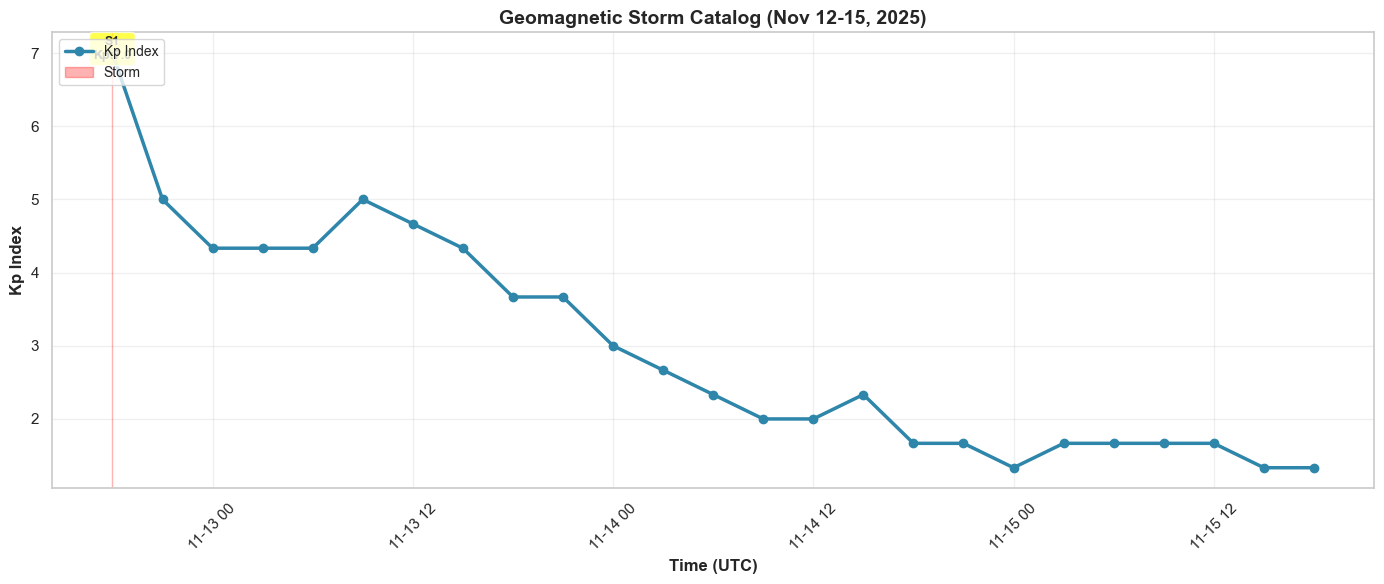

In [9]:
# Visualization 3: Storm Catalog Timeline
if len(storm_catalog) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot Kp time series
    ax.plot(kp_data['Time (UTC)'], kp_data['median'], 
            linewidth=2.5, color='#2E86AB', marker='o', markersize=6, label='Kp Index')
    
    # Highlight storm periods
    for idx, storm in storm_catalog.iterrows():
        ax.axvspan(storm['Start_Time'], storm['End_Time'], 
                   alpha=0.3, color='red', label='Storm' if idx == 0 else '')
        
        # Add storm ID label
        mid_time = storm['Start_Time'] + (storm['End_Time'] - storm['Start_Time']) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.95, 
                f"S{storm['Storm_ID']}\nKp:{storm['Peak_Kp']:.1f}",
                ha='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    ax.set_xlabel('Time (UTC)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Kp Index', fontsize=12, fontweight='bold')
    ax.set_title('Geomagnetic Storm Catalog (Nov 12-15, 2025)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    fig.savefig('../outputs/figures/08_storm_catalog.png', dpi=300, bbox_inches='tight')
    print('✓ Figure saved: 08_storm_catalog.png')
    plt.show()
else:
    print('No storms to visualize')

In [10]:
print('\n' + '='*70)
print('PHASE 3 ANALYSIS SUMMARY')
print('='*70)

print(f'\nData Period Analyzed:')
print(f'  Kp data: {kp_data["Time (UTC)"].min()} to {kp_data["Time (UTC)"].max()}')
print(f'  Total observations: {len(kp_data)}')

print(f'\nKp Index Statistics:')
print(f'  Mean: {kp_data["median"].mean():.2f}')
print(f'  Median: {kp_data["median"].median():.2f}')
print(f'  Std Dev: {kp_data["median"].std():.2f}')
print(f'  Range: {kp_data["median"].min():.2f} - {kp_data["median"].max():.2f}')

print(f'\nGeomagnetic Activity Classification:')
for severity in ['Quiet', 'Unsettled', 'Active', 'Minor Storm', 'Moderate Storm', 'Strong Storm', 'Severe Storm']:
    count = (events_df['Severity'] == severity).sum()
    if count > 0:
        pct = (count / len(events_df)) * 100
        print(f'  {severity}: {count} ({pct:.1f}%)')

print(f'\nStorm Summary:')
if len(storm_catalog) > 0:
    print(f'  Total distinct storms detected: {len(storm_catalog)}')
    print(f'  Average storm duration: {storm_catalog["Duration_Hours"].mean():.1f} hours')
    print(f'  Longest storm duration: {storm_catalog["Duration_Hours"].max():.1f} hours')
    print(f'  Peak Kp reached: {storm_catalog["Peak_Kp"].max():.2f}')
    print(f'  Average peak Kp: {storm_catalog["Peak_Kp"].mean():.2f}')
else:
    print(f'  No storms detected (Kp < 5 threshold)')

print(f'\nNote on Data:')
print(f'  Solar wind data (Aug 15-20) does NOT overlap with Kp data (Nov 12-15)')
print(f'  Lag/correlation analysis will be performed in Phase 4 with aligned dataset')

print('\n' + '='*70)
print('✓ PHASE 3 COMPLETE - Ready for Phase 4: Impact Assessment')
print('='*70)


PHASE 3 ANALYSIS SUMMARY

Data Period Analyzed:
  Kp data: 2025-11-12 18:00:00 to 2025-11-15 18:00:00
  Total observations: 25

Kp Index Statistics:
  Mean: 2.99
  Median: 2.33
  Std Dev: 1.54
  Range: 1.33 - 7.00

Geomagnetic Activity Classification:
  Quiet: 17 (68.0%)
  Unsettled: 5 (20.0%)
  Active: 2 (8.0%)
  Moderate Storm: 1 (4.0%)

Storm Summary:
  Total distinct storms detected: 1
  Average storm duration: 0.0 hours
  Longest storm duration: 0.0 hours
  Peak Kp reached: 7.00
  Average peak Kp: 7.00

Note on Data:
  Solar wind data (Aug 15-20) does NOT overlap with Kp data (Nov 12-15)
  Lag/correlation analysis will be performed in Phase 4 with aligned dataset

✓ PHASE 3 COMPLETE - Ready for Phase 4: Impact Assessment
